# Generating all images in this notebook

eas: file ->snesim/data/reference_ti
eas: title->    grid (150x150x1)
eas: file ->snesim/data/samples50
eas: title->           eas title


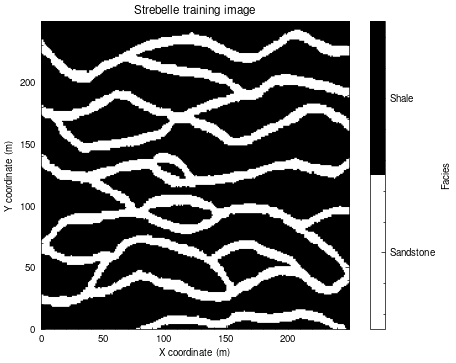

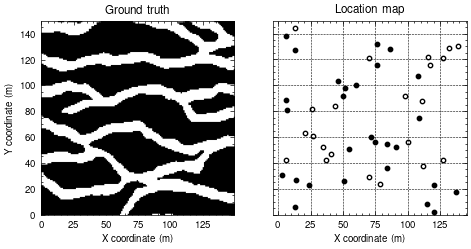

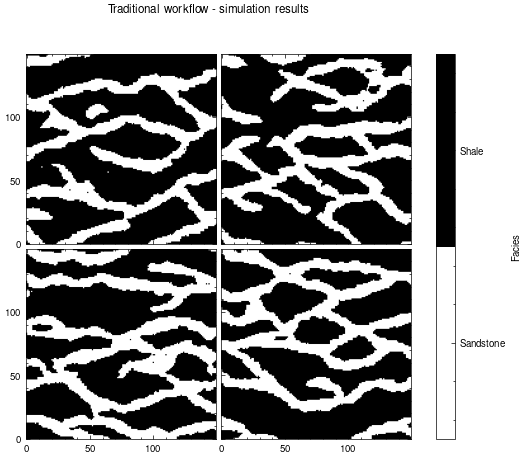

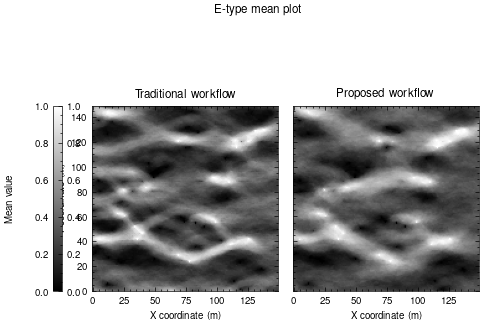

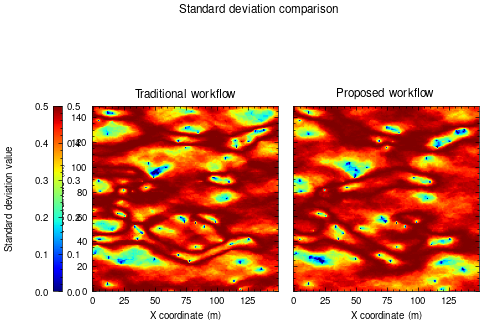

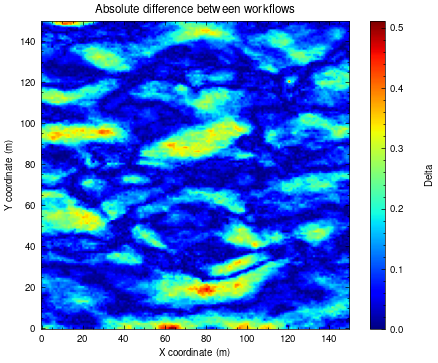

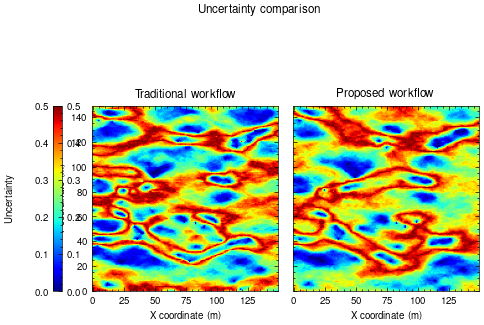

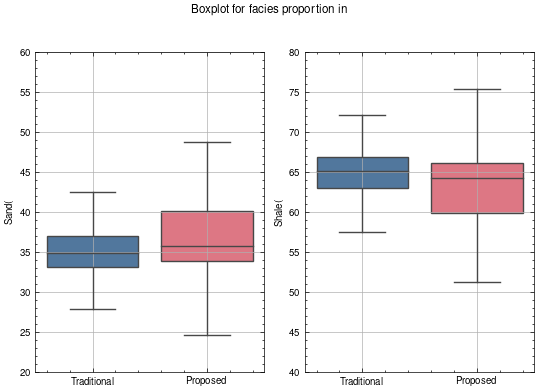

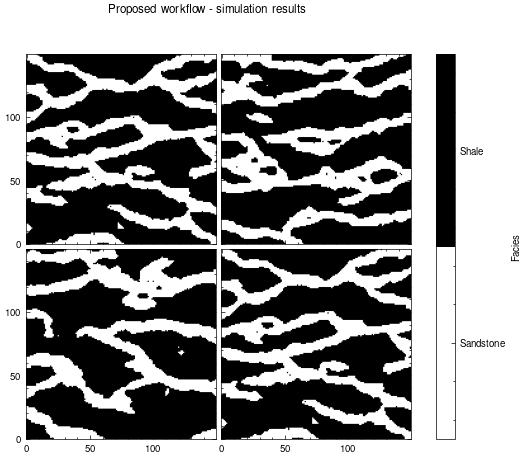

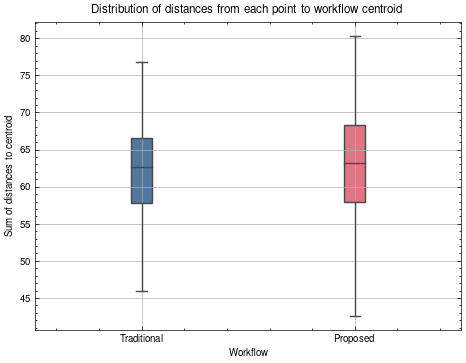

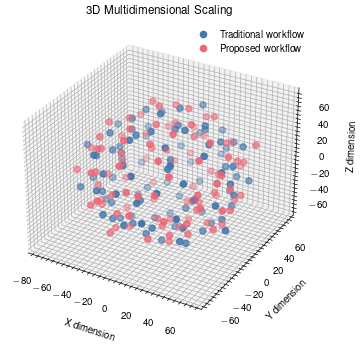

In [4]:
from typing import Any, Tuple
from mpl_toolkits.axes_grid1 import ImageGrid
from snesim.snesim import calculate_uncertainty, read_conditional_samples
from generative_model.graphics.plot import *

import cv2
import random
import seaborn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

random.seed(69096)

plt.style.use(["science", "nature", "bright"])


class Plots:
    def __init__(self) -> None:
        self.figsize: Tuple = (5.5, 4)
        self.binary_cmap: str = "gray"

        mpl.rcParams["savefig.dpi"] = 300
        mpl.rcParams["figure.dpi"] = 100

        self.reference_ti, self.samples = self.load_samples()
        self.snesim = np.load("snesim/data/realizations.npy").reshape((100, 150, 150))
        self.gan = np.load("generative_model/data/realizations.npy").reshape(
            (100, 150, 150)
        )
        self.snesim_df, self.gan_df = self.get_dict_realizations()

        self.__plot_all()

    def get_dict_realizations(self):
        snesim_df = dict()
        for idx, realization in enumerate(self.snesim):
            snesim_df[f"ti_{idx+1}"] = np.array(realization.reshape(-1))

        gan_df = dict()

        for idx, realization in enumerate(self.gan):
            gan_df[f"ti_{idx+1}"] = np.array(realization.reshape(-1))

        return pd.DataFrame(snesim_df), pd.DataFrame(gan_df)

    def __plot_all(self):
        self.strebelle()
        self.location_map(self.reference_ti, self.samples)
        self.snesim_realizations_grid()
        self.etype()
        self.std_plot()
        self.absolute_difference()
        self.plot_uncertainty()
        self.proportions_comparison(
            self.snesim.reshape(100, -1), self.gan.reshape(100, -1)
        )
        self.gan_realizations_grid()
        self.mds()
        return True

    def load_samples(self):
        file = read_conditional_samples("snesim/data/reference_ti")["D"]
        reference_ti = file.reshape(1, 150, 150)[0, :, :]

        conditioning_data = read_conditional_samples("snesim/data/samples50")["D"]

        # Samples to dataframe
        samples = pd.DataFrame()

        samples["x"] = conditioning_data[:, 0]
        samples["y"] = conditioning_data[:, 1]
        samples["class"] = conditioning_data[:, 3]
        return reference_ti, samples

    @staticmethod
    def _get_categorical_cb():
        cmap = mpl.colors.ListedColormap(["white", "black"])

        col_dict = {0: "white", 1: "black"}
        norm_bins = np.sort([*col_dict.keys()]) + 0.5
        norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

        norm = mpl.colors.BoundaryNorm(norm_bins, 2, clip=True)

        labels = np.array(["Sandstone", "Shale"])
        fmt = mpl.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

        diff = norm_bins[1:] - norm_bins[:-1]
        tickz = norm_bins[:-1] + diff / 2

        colorbar = plt.colorbar(
            mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
            ticks=tickz,
            format=fmt,
            spacing="proportional",
            label="Facies",
        )

        return colorbar

    def strebelle(self, ti_path: str = "generative_model/strebelle.png"):
        ti = cv2.imread(ti_path)
        fig, ax = plt.subplots(figsize=self.figsize)

        ax.imshow(ti, cmap=self.binary_cmap, origin="lower")
        plt.title("Strebelle training image")
        plt.xlabel("X coordinate (m)")
        plt.ylabel("Y coordinate (m)")

        cb = self._get_categorical_cb()
        plt.grid(False)

    def location_map(self, reference_ti, samples):
        fig, ax = plt.subplots(1, 2, figsize=self.figsize, sharey=True)

        ax[0].imshow(reference_ti, cmap="gray", origin="lower")
        ax[0].set_title("Ground truth")
        ax[0].set_xlabel("X coordinate (m)")
        ax[0].set_ylabel("Y coordinate (m)")

        for row_sampled in samples.values:
            x, y, class_ = row_sampled[0], row_sampled[1], row_sampled[2]
            if class_ == 0:
                ax[1].scatter(x, y, marker="o", color="black", s=10)
            else:
                ax[1].scatter(x, y, marker="o", c="white", edgecolors="black", s=10)

        # Plotting the samples
        ax[1].set_title("Location map")
        ax[1].set_xlabel("X coordinate (m)")
        # ax[1].set_ylabel("Y coordinate (m)")
        ax[1].grid(True, linestyle="--", color="black", linewidth=0.4)

        plt.gca().set_aspect("equal")

    def snesim_realizations_grid(self):
        rand_idx = [
            random.randint(0, len(self.snesim) - 1) for _ in range(len(self.snesim))
        ]
        tis_sampled = [self.snesim[i] for i in rand_idx]

        fig = plt.figure(figsize=(8, 5))

        sq = round(len(self.snesim))

        image_grid = ImageGrid(
            fig,
            111,
            nrows_ncols=(2, 2),
            axes_pad=0.05,
            cbar_location="left",
            cbar_pad=0.15,
        )

        cb = self._get_categorical_cb()
        fig.suptitle("Traditional workflow - simulation results")

        for ax, image in zip(image_grid, tis_sampled):
            # Reshapes image to desired size
            reshaped = image.reshape(150, 150)
            # Iterating over the grid returns the Axes.
            ax.imshow(reshaped, cmap="gray", origin="lower")

            # Adjust axis ticks
            ax.set_xticks(range(0, 150, 50))
            ax.set_yticks(range(0, 150, 50))
        plt.grid(False)

    def etype(self):
        fig = plt.figure(figsize=self.figsize)

        grid = ImageGrid(
            fig,
            111,
            nrows_ncols=(1, 2),
            axes_pad=0.15,
            share_all=True,
            cbar_location="left",
            cbar_mode="single",
            cbar_pad=0.15,
        )

        plt.suptitle("E-type mean plot")

        # Labels and titles
        grid[0].set_title("Traditional workflow")
        grid[1].set_title("Proposed workflow")
        grid[0].set_ylabel("Y coordinate (m)")

        # Add data to image grid
        for ax, im in zip(
            grid,
            (
                self.snesim.reshape(100, 150, 150).mean(axis=0),
                self.gan.reshape(100, 150, 150).mean(axis=0),
            ),
        ):
            im = ax.imshow(im, cmap="gray", origin="lower")
            ax.set_xlabel("X coordinate (m)")

        # Colorbar
        cb = ax.cax.colorbar(im)
        cb.ax.get_yaxis().labelpad = 15
        cb.set_label("Mean value")
        ax.cax.toggle_label(True)
        plt.grid(False)

    def std_plot(self):
        fig = plt.figure(figsize=self.figsize)

        grid = ImageGrid(
            fig,
            111,
            nrows_ncols=(1, 2),
            axes_pad=0.15,
            share_all=True,
            cbar_location="left",
            cbar_mode="single",
            cbar_pad=0.15,
        )

        plt.suptitle("Standard deviation comparison")

        # Labels and titles
        grid[0].set_title("Traditional workflow")
        grid[1].set_title("Proposed workflow")
        grid[0].set_ylabel("Y coordinate (m)")

        # Add data to image grid
        for ax, im in zip(
            grid,
            (
                self.snesim.reshape(100, 150, 150).std(axis=0),
                self.gan.reshape(100, 150, 150).std(axis=0),
            ),
        ):
            im = ax.imshow(im, cmap="jet", origin="lower")
            ax.set_xlabel("X coordinate (m)")

        # Colorbar
        cb = ax.cax.colorbar(im)
        cb.ax.get_yaxis().labelpad = 15
        cb.set_label("Standard deviation value")
        ax.cax.toggle_label(True)
        plt.grid(False)

    def absolute_difference(self):
        fig, ax = plt.subplots(1, 1, figsize=self.figsize)

        # Labels and titles
        ax.set_title("Absolute difference between workflows")
        ax.set_xlabel("X coordinate (m)")
        ax.set_ylabel("Y coordinate (m)")

        # Add data to image grid
        im = ax.imshow(
            np.abs(
                self.snesim.reshape(100, 150, 150).mean(axis=0)
                - self.gan.reshape(100, 150, 150).mean(axis=0)
            ),
            cmap="jet",
            origin="lower",
        )

        # Colorbar
        cb = plt.colorbar(im)
        cb.ax.get_yaxis().labelpad = 15
        cb.set_label("Delta")
        plt.grid(False)

    @staticmethod
    def calculate_uncertainty(dict_ti: pd.DataFrame):
        _data = dict_ti.copy()

        _data["prob_sand"] = _data.mean(axis=1)
        _data["prob_shale"] = 1 - _data["prob_sand"]

        _data["uncertainty"] = _data[["prob_shale", "prob_sand"]].min(axis=1)

        _data.drop("prob_sand", axis=1, inplace=True)
        _data.drop("prob_shale", axis=1, inplace=True)

        return _data

    def plot_uncertainty(self):
        snesim_unc = calculate_uncertainty(self.snesim_df)
        gan_unc = calculate_uncertainty(self.gan_df)

        fig = plt.figure(figsize=self.figsize)

        grid = ImageGrid(
            fig,
            111,
            nrows_ncols=(1, 2),
            axes_pad=0.15,
            share_all=True,
            cbar_location="left",
            cbar_mode="single",
            cbar_pad=0.15,
        )

        plt.suptitle("Uncertainty comparison")

        # Labels and titles
        grid[0].set_title("Traditional workflow")
        grid[1].set_title("Proposed workflow")
        grid[0].set_ylabel("Y coordinate (m)")

        # Add data to image grid
        for ax, im in zip(grid, (snesim_unc, gan_unc)):
            im = ax.imshow(
                im["uncertainty"].values.reshape(150, 150), cmap="jet", origin="lower"
            )
            ax.set_xlabel("X coordinate (m)")

        # Colorbar
        cb = ax.cax.colorbar(im)
        cb.ax.get_yaxis().labelpad = 15
        cb.set_label("Uncertainty")
        ax.cax.toggle_label(True)
        plt.grid(False)

    @staticmethod
    def get_dicts(realization):
        sand_values = list()
        shale_values = list()

        # Get proportions for real data
        for i in range(1, len(realization)):
            sand, shale = get_sand_shale_proportion(realization[i].reshape(-1))
            sand_values.append(sand)
            shale_values.append(shale)

        df_dict = dict(Sand=sand_values, Shale=shale_values)
        df = pd.DataFrame.from_dict(df_dict, orient="columns")
        return df

    def proportions_comparison(self, real: np.ndarray, fake: np.ndarray) -> None:
        fig, ax = plt.subplots(1, 2, figsize=self.figsize)
        fig.suptitle("Boxplot for facies proportion in %")

        df_snesim = self.get_dicts(real)
        df_gan = self.get_dicts(fake)

        # Create categories for both DataFrames
        df_snesim["Facies"] = np.where((df_snesim["Sand"] > 50.0), "Sand", "Shale")
        df_snesim["Workflow"] = "Traditional"

        df_gan["Facies"] = np.where((df_gan["Sand"] > 50.0), "Sand", "Shale")
        df_gan["Workflow"] = "Proposed"

        # Concatenate and pĺot
        df_prop = pd.concat([df_snesim, df_gan])

        seaborn.boxplot(
            data=df_prop, x="Workflow", y="Sand", ax=ax[0], showfliers=False
        ).set_xlabel(None)
        seaborn.boxplot(
            data=df_prop, x="Workflow", y="Shale", ax=ax[1], showfliers=False
        ).set_xlabel(None)

        ax[0].set_ylabel("Sand(%)")
        ax[1].set_ylabel("Shale(%)")
        fig.subplots_adjust(right=1.5)
        ax[0].set_ylim(20, 60)
        ax[1].set_ylim(40, 80)
        ax[0].grid(True)
        ax[1].grid(True)

        fig.tight_layout(rect=[0, 0, 1, 0.95])

    def gan_realizations_grid(self):
        rand_idx = [random.randint(0, len(self.gan) - 1) for _ in range(len(self.gan))]
        tis_sampled = [self.gan[i] for i in rand_idx]

        fig = plt.figure(figsize=(8, 5))

        sq = round(len(self.gan))

        image_grid = ImageGrid(
            fig,
            111,
            nrows_ncols=(2, 2),
            axes_pad=0.05,
            cbar_location="left",
            cbar_pad=0.15,
        )

        cb = self._get_categorical_cb()

        fig.suptitle("Proposed workflow - simulation results")

        for ax, image in zip(image_grid, tis_sampled):
            # Reshapes image to desired size
            reshaped = image.reshape(150, 150)

            # Iterating over the grid returns the Axes.
            ax.imshow(reshaped, cmap="gray", origin="lower")

            # Adjust axis ticks
            ax.set_xticks(range(0, 150, 50))
            ax.set_yticks(range(0, 150, 50))

    def mds_calculus(self):
        traditional = self.snesim.reshape(100, -1)
        proposed = self.gan.reshape((100, -1))

        mds = MDS(n_components=3, metric=True, random_state=0)

        # Get the embeddings
        original = mds.fit_transform(traditional)

        # Get the embeddings
        gan = mds.fit_transform(proposed)
        return original, gan

    @staticmethod
    def centroidnp(arr):
        length, dim = arr.shape
        return np.array([np.sum(arr[:, i]) / length for i in range(dim)])

    def distance_boxplot(self, traditional, proposed):
        import operator as op

        fig, ax = plt.subplots(1, 1, figsize=self.figsize)

        plot_data = {
            "Traditional": traditional,
            "Proposed": proposed,
        }

        # sort keys and values together
        sorted_keys, sorted_vals = zip(*sorted(plot_data.items(), key=op.itemgetter(1)))

        ax.set(xlabel="Workflow", ylabel="Sum of distances to centroid")
        seaborn.boxplot(data=sorted_vals, width=0.1, showfliers=False)

        # category labels
        plt.xticks(plt.xticks()[0], sorted_keys)
        plt.title("Distribution of distances from each point to workflow centroid")
        plt.grid(True)

    def mds3d(self, traditional_coord, proposed_coord):
        # set up a figure twice as wide as it is tall
        fig = plt.figure(figsize=self.figsize)
        ax = fig.add_subplot(1, 1, 1, projection="3d")

        ax.set_title("3D Multidimensional Scaling")
        ax.set_xlabel("X dimension")
        ax.set_ylabel("Y dimension")
        ax.set_zlabel("Z dimension")

        x_traditional, y_traditional, z_traditional = traditional_coord.T
        x_proposed, y_proposed, z_proposed = proposed_coord.T

        ax.scatter3D(x_traditional, y_traditional, z_traditional)

        ax.scatter3D(x_proposed, y_proposed, z_proposed)

        ax.legend(["Traditional workflow", "Proposed workflow"])

    def mds(self):
        original, gan = self.mds_calculus()
        x_t, y_t, z_t = original.T
        x_p, y_p, z_p = gan.T

        trad_centroid = self.centroidnp(original)
        prop_centroid = self.centroidnp(gan)

        import math

        dist_trad = [math.dist(point, trad_centroid) for point in original]
        dist_prop = [math.dist(point, prop_centroid) for point in gan]

        self.distance_boxplot(dist_trad, dist_prop)
        self.mds3d(original, gan)


plotter = Plots()

# TODO:
- ~Uncertainty histogram~
- MDS validation